In [52]:
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题
from IPython.display import Latex

# 接受-拒绝采样

假设目标分布 $ \pi(X) $ 、建议分布 $ q(X)$、均匀分布 $ u \sim U(0,1) $ ，其中 $ u \sim U(0,1) $ $ M q(X) \geq \pi(X) $  



实际上要证明的东西就是 $ p(x \mid accept)=\pi(x) $ ，也即被接受样本 $ x $ 的分布和应该目标 分布一样，想到这点后面就水到渠成了:
1. 先写贝叶斯成联合概率：
$$
p(x \mid accept)=\frac{p(x, accept)}{\int_{X} p(x, a c c p e t) d x}
$$
2. 又由于先验 $ p(x) $ 即建议分布 $ q(x) $, 且 $ u $ 与 $ x $ 无关, 因此：
$$\begin{aligned}
p(x, accept) &= p(accept\mid x)  p(x) = q(x) \int_{U} p(accept \mid x, u) p(u \mid x) d u \\
&= q(x) \int_{U} p(accept \mid x, u) p(u) d u
\end{aligned}
$$
3. $ p(accept \mid x, u) $ 即给定 $ u, x $ 时, $ accept $ 的概率：
$$
p(accept\mid x,u)=\left\{\begin{array}{ll}1, & u \leq \frac{\pi(x)}{M q(x)} \\ 0, & \text { otherwise }\end{array}\right. $$  
4. 又由于 $ M q(X) \geq \pi(X) $ 得 $ 0 \leq \frac{\pi(x)}{M q(x)} \leq 1 $ 因此有:
$$
p(x, accept)=q(x) \int_{0}^{\frac{\pi(x)}{M(x)}} p(u) d u=q(x) \frac{\pi(x)}{M q(x)}=\frac{\pi(x)}{M}
$$
5. 带入到 $ p(x \mid accept) $ :
$$
\begin{aligned}
p(x \mid accept) &=\frac{p(x, accept)}{\int_{X} p(x, a c c p e t) d x} \\
&=\frac{\frac{\pi(x)}{M}}{\int_{X} \frac{\pi(x)}{M} d x}=\frac{\pi(x)}{\int_{X} \pi(x) d x}=\pi(x)
\end{aligned}
$$
6. 得证。

In [25]:
## 待采样分布
p_pdf = lambda x: (norm.pdf(x,loc=30,scale=10)+norm.pdf(x,loc=80,scale=20))/2

In [2]:
## 建议分布
q_pdf = lambda x: norm.pdf(x,loc=50,scale=30)

In [26]:
## 求包络系数M
X = np.arange(-50,151)
X_p, X_q = p_pdf(X), q_pdf(X)
M = np.max(X_p/X_q)

In [8]:
## 接受-拒绝过程
def acc_rej(n=1e5):
    
    ## 按建议分布q生成数据z
    z = norm.rvs(loc=50,scale=30,size=int(n))

    ## 生成数据z 的p(x) 和 q(x)
    p_z = p_pdf(z)
    q_z = q_pdf(z)
    u = np.random.uniform(low=0,high = M*q_z)
    
    ## 返回接受样本作为采样结果
    return z[u<=p_z]

In [27]:
s = acc_rej(1e7)
s[:10]

array([33.35730588, 13.1378048 , 36.65669596, 97.362627  , 39.09991424,
       95.71160666, 22.33801697, 78.12442396, 66.86439091, 80.06806906])

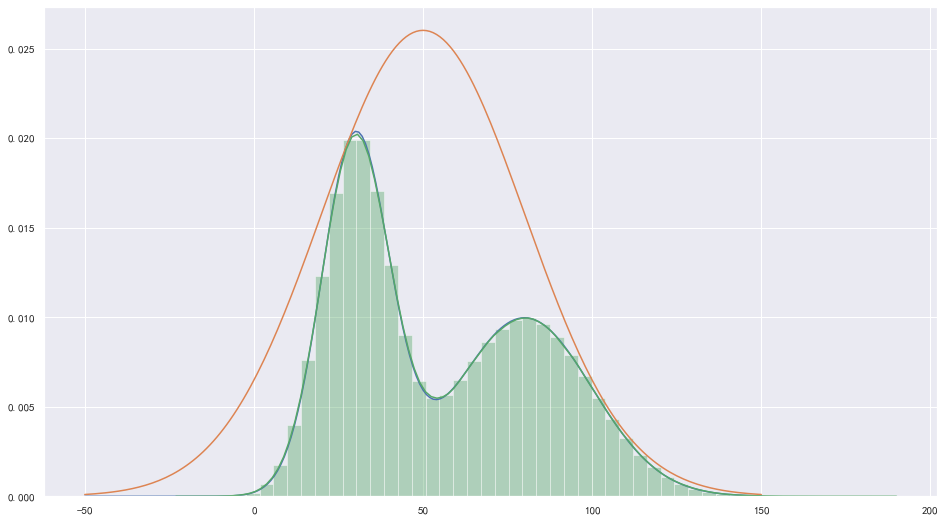

In [28]:
plt.figure(figsize=[16,9])
plt.plot(X,X_p,label='采样分布p')
plt.plot(X,X_q*M,label='建议分布q')
sns.distplot(s,label='采样结果')

# M-H采样

In [15]:
## 概率密度函数 π
p_pdf = lambda x: (norm.pdf(x,loc=30,scale=10)+norm.pdf(x,loc=80,scale=20))/2
# 定义域【-20,170】

In [16]:
## 任意概率密度转移矩阵 Q 
# Q选择定义域上的均匀分布，q=lambda i: 1/(170+20)  所以Q是对称的。

In [18]:
## 初始化x0：
X = [np.random.random()*190-20] ## 用定义域[-20,170]的均匀分布生成初始值
## 采样
for _ in range(100000):
    x_next = np.random.random()*190-20 ## Q是定义域上的均匀分布，根据Q采样x_next
    alpha = min(p_pdf(x_next)/p_pdf(X[-1]),1) ## 计算alpha，Q是对称的，所以可约去Q
    X.append(x_next if alpha>np.random.uniform() else X[-1]) ## 使用一个随机数判断是否接受

In [23]:
X[90000:90000+20]

[92.5887678371377,
 29.419663178522327,
 29.419663178522327,
 61.52304121534999,
 61.52304121534999,
 48.23828449736588,
 48.23828449736588,
 39.926784794390514,
 39.926784794390514,
 39.926784794390514,
 39.926784794390514,
 39.926784794390514,
 39.926784794390514,
 39.926784794390514,
 39.926784794390514,
 39.926784794390514,
 39.926784794390514,
 39.926784794390514,
 39.926784794390514,
 81.45950082061466]

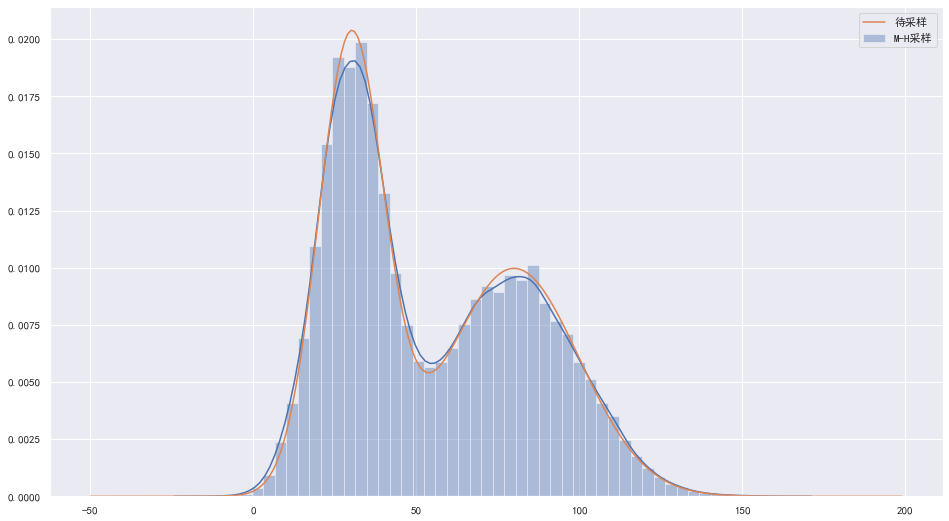

In [22]:
plt.figure(figsize=[16,9])
sns.distplot(X[-90000:],label='M-H采样')
sns.lineplot(np.arange(-50,200),p_pdf(np.arange(-50,200)),label='待采样')

# Gibbs采样

In [29]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

avg1,avg2 = 0.5,-0.2
std1,std2 = 1.5,0.7
ro = 0.5

In [30]:
## 概率密度函数 π
p_pdf = lambda x: multivariate_normal([avg1, avg2], [[std1*std1, ro*std1*std2], [ro*std1*std2, std2*std2]]).pdf(x)
# 定义域【-5,5】
X = np.random.uniform([-5, -5], [5,5], [10000, 2])
z = p_pdf(X)

In [34]:
## 随机初始值
X = np.random.uniform([-5, -5], [5,5], [1, 2]).tolist()
## 采样
scale1,scale2 = np.sqrt((1-ro*ro)*std1*std1),np.sqrt((1-ro*ro)*std2*std2)
loc1,loc2 = lambda x:avg1+ro*std1/std2*(x-avg2), lambda x:avg2+ro*std2/std1*(x-avg1)
for _ in range(100000):
    x1_next = norm.rvs(loc=loc1(X[-1][1]), scale = scale1) ## x2-->x1_new
    x2_next = norm.rvs(loc=loc2(x1_next), scale = scale2) ## x1_new-->x2_new
    X.append([x1_next,x2_next])
X = np.array(X)

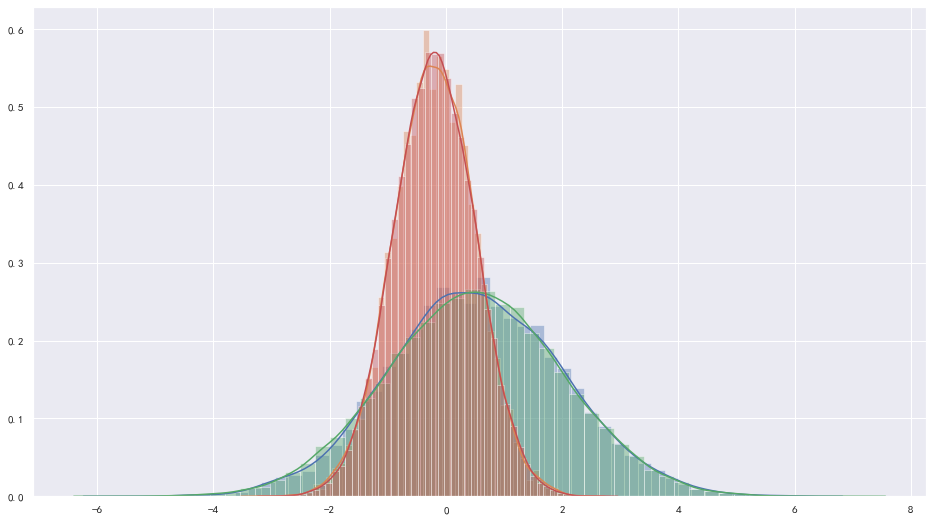

In [37]:
plt.figure(figsize=[16,9])
sns.distplot(test[:,0],label='test-X')
sns.distplot(test[:,1],label='test-Y')
sns.distplot(X[-50000:,0],label='sampled-X')
sns.distplot(X[-50000:,1],label='sampled-Y')